<a href="https://colab.research.google.com/github/cpnecesario/cpnecesario/blob/Academics/Diffusion_Limited_Aggregation_from_Numfys.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline
import numpy as np
from math import ceil, floor
import matplotlib.pyplot as plt
import progressbar
import warnings
from scipy.optimize import curve_fit 

In [ ]:
def DLA(particles, seed, stickiness, L=1000, STEP_CHUNCK=200, range_length=100, start_length=10):
    """ Performs the Diffusion Limited Aggregation model on a lattice for a 
    given amount of particles and a given seed. Try to optimize optional arguments!
    Parameters:
        particles:    int. Number of particles.
        seed:         array-like, mxn, m,n < L. Seed.
        stickiness:   float. 'Sticking' probability. Should be in the range [0,1].
        L:            int. Size of the lattice. The lattice will become a (2L+1)x(2L+1).
        STEP_CHUNCK:  int. Specifies the number of steps calculated at once.
        range_length: int. Length at which the particles are considered "out of range".
        start_length: int. Length at which the particles are created.
    Output:
        lattice:     (2L+1)x(2L+1) numpy array. Array describing the cluster. The
                     entries are 0 at empty position and n for the n'th particle.
        max_radius:  float. The maximum radius of the lattice.
    """

    # Define possible steps and adjacent cells
    STEPS = np.array([(0,1), (0,-1), (1,0), (-1,0)])
    ADJACENT = np.array([(0,1), (0,-1), (1,0), (-1,0), (1,1), (1,-1), (-1,1), (-1,-1)])

    # Create empty lattice
    lattice_size = 2*L + 1
    lattice = np.zeros((lattice_size, lattice_size), dtype='int32')

    # Create a cluster. That is, a lattice holding all 'adjacent cells'
    cluster = (lattice != 0)
    # Set the seed in the midle of the lattice
    seed = (seed != 0) # Set all entries to one or zero
    seed_size = np.array([np.size(seed,0), np.size(seed,1)])
    l = seed_size/2
    cluster[ceil(L - l[0]):ceil(L + l[0]), ceil(L - l[1]):ceil(L + l[1])] = seed
    # We define the 'start maximal radius' as being the maximal radius of the seed.
    max_radius = (np.size(seed,0)**2 + np.size(seed,1)**2)**.5
    lattice = np.copy(cluster)*particles

    ### Performing the simulation ###
    angles = np.random.rand(particles)*2*np.pi # One random angle per particle

    bar = progressbar.ProgressBar()
    for i in bar(range(particles)):

        # Setting inital position
        x = int((max_radius + start_length)*np.cos(angles[i]) + L)
        y = int((max_radius + start_length)*np.sin(angles[i]) + L)

        while True:
            # Performing one step chunck og STEP_CHUNK number of steps. This idea was inspired by
            # https://github.com/hemmer/pyDLA/blob/numpyFast/dla.py
            steps = np.random.randint(0,4,STEP_CHUNCK)
            steps = np.cumsum(STEPS[steps], axis=0)
            steps[:,0] += x
            steps[:,1] += y 
            # Check at which positions in the chunck the particle is adjacent to the cluster
            adjacent = cluster[steps[:,0], steps[:,1]]

            if np.any(adjacent): # If at least one of the positions are adjacent
                # If the stickiness is 100%, the particle will be stuck at the first adjacent position
                first_hit = adjacent.nonzero()[0][0]
                x = steps[first_hit, 0]
                y = steps[first_hit, 1]
                current_radius = (x - L)**2 + (y - L)**2
                # If not, we should perform only single steps at the time, and only allow steps that
                # does not collide with existing particles. At each adjacent position, there are a
                # probability of sticking. If the particle goes outside the maximum radius of the
                # cluster, we forget about it and introduce a new
                if (stickiness < 1):
                    is_attached = (np.random.rand(1) < stickiness)
                    inside = (current_radius < (max_radius + 2)**2)
                    while ((not is_attached) and inside):
                        while True:
                            r = np.random.randint(1,5)
                            if (r == 1 and (not lattice[x + 1, y])):
                                x += 1
                                break
                            elif (r == 2 and (not lattice[x - 1, y])):
                                x -= 1
                                break
                            elif (r == 3 and (not lattice[x, y + 1])):
                                y += 1
                                break
                            elif (r == 4 and (not lattice[x, y - 1])):
                                y -= 1
                                break
                        if (cluster[x, y]):
                            is_attached = (np.random.rand(1) < stickiness)
                        current_radius = (x - L)**2 + (y - L)**2
                        inside = (current_radius < (max_radius + 2)**2)
                    if (not inside):
                        new_angle = np.random.rand(1)*2*np.pi
                        x = int((max_radius + start_length)*np.cos(new_angle) + L)
                        y = int((max_radius + start_length)*np.sin(new_angle) + L)
                    else:
                        lattice[x, y] = i
                        cluster[ADJACENT[:, 0] + x, ADJACENT[:, 1] + y] = True
                        if (current_radius > max_radius**2):
                            max_radius = current_radius**.5
                        break
                else:
                    # Put the particle number into the lattice at current position,
                    # if it is adjacent to the cluster
                    lattice[x, y] = i
                    # Update adjacent cells
                    cluster[ADJACENT[:, 0] + x, ADJACENT[:, 1] + y] = True
                    # Update the cluster radius
                    if (current_radius > max_radius**2):
                        max_radius = current_radius**.5
                    break

            else:
                x = steps[-1,0]
                y = steps[-1,1]
                # If the last posision in the chunck is out of range, then introduce a new particle
                current_radius = (x - L)**2 + (y - L)**2
                if (current_radius > (max_radius + range_length)**2):
                    new_angle = np.random.rand(1)*2*np.pi
                    x = int((max_radius + start_length)*np.cos(new_angle) + L)
                    y = int((max_radius + start_length)*np.sin(new_angle) + L)
    return lattice, max_radius

In [ ]:
def DLA_sim(particles=10000, stickiness=1, seed=np.ones((1,1))):
    """ Calls DLA() and visualizes the results.
    Parameters: Same as DLA()
    Output:
        lattice_gray_cut: numpy array. Cropped array describing the cluster. The
                          entries are 0 at empty position and n for the n'th particle.
        lattice_cut:      numpy array. Cropped array describing the cluster. The
                          entries are 0 at empty position and 1 otherwise.
        max_radius:       float. The maximum radius of the lattice.
    """
    # Perform simulation
    lattice, max_radius = DLA(particles, seed, stickiness)
    # Create a corresponding black/white lattice
    lattice_gray = (lattice != 0)
    # Crop
    mask = np.ix_(lattice_gray.any(1),lattice_gray.any(0)) # Create a 'crop mask'
    lattice_gray_cut = lattice_gray[mask]
    lattice_cut = lattice[mask]
    print("Maximum radius: ", max_radius)
    # Plot results
    plt.figure()
    plt.suptitle("DLA-cluster with %d particles and stickiness %.2f" % (particles, stickiness))
    plt.subplot(121)
    plt.imshow(lattice_cut, interpolation='none')
    plt.subplot(122)
    plt.imshow(lattice_gray_cut, interpolation='none', cmap='gray')
    plt.show()
    return lattice_gray_cut, lattice_cut, max_radius

100% (10000 of 10000) |##################| Elapsed Time: 0:01:11 Time:  0:01:11


Maximum radius:  286.75425018646195


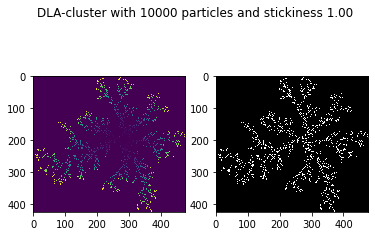

100% (10000 of 10000) |##################| Elapsed Time: 0:00:34 Time:  0:00:34


Maximum radius:  209.03827400741713


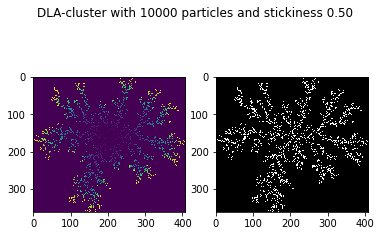

100% (10000 of 10000) |##################| Elapsed Time: 0:00:25 Time:  0:00:25


Maximum radius:  137.78606605894515


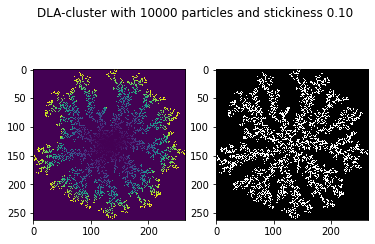

In [ ]:
lattice = DLA_sim(stickiness=1.00)
DLA_sim(stickiness=0.50);
DLA_sim(stickiness=0.10);